# PBL 1 - Repowering a Commercial Site

A commercial building owner seeking advice on what to do with their PV systems as their rooftop ages: decommissioning the system, reinstalling the current setup after roof maintenance, or repowering with newer, more efficient technology


## 0. Python Imports

If running on google colab, the below cell will Install the requirements as well as download the files into your working space.


In [35]:
import os

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    print("Running in Google Colab — Installing and Downloading files...")
    !pip install -r https://raw.githubusercontent.com/PV-Tutorials/2025_PVPMC_PV_Repowering/main/requirements.txt
    
    base_url = "https://raw.githubusercontent.com/PV-Tutorials/2025_PVPMC_PV_Repowering/main/data/"
    files = ["CA_weather_data.csv", "CO_weather_data.csv", "repower_weather_file.csv", "weather_file.csv"]
    
    folder_name = "data"
    os.makedirs(folder_name, exist_ok=True)
    
    # Download each file into the folder
    for file in files:
        !wget -q -O {os.path.join(folder_name, file)} {base_url + file}
    
    # List the files to confirm
    !ls {folder_name}
    
    
    
    base_url = "https://raw.githubusercontent.com/PV-Tutorials/2025_PVPMC_PV_Repowering/main/PBL%201_Data/"
    files = ["reinstall_-_upfront_cost_cashloan.json", 
             "reinstall_-_upfront_cost_grid.json", 
             "reinstall_-_upfront_cost_pvsamv1.json", 
             "reinstall_-_upfront_cost_utilityrate5.json"]
    
    folder_name = "PBL_1_Data"
    os.makedirs(folder_name, exist_ok=True)
    
    # Download each file into the folder
    for file in files:
        !wget -q -O {os.path.join(folder_name, file)} {base_url + file}
    
    # List the files to confirm
    !ls {folder_name}

else:
    print("Not in Colab — skipping Install and downloads.")

Not in Colab — skipping Install and downloads.


In [2]:
#Imports
import PySAM
import PV_ICE
import pandas as pd
import numpy as np
import json
import os
from PySAM import Pvsamv1 as pv
from PySAM import Pvwattsv8 as pvwatts
from PySAM import Cashloan as com
from PySAM import Grid as grid
from PySAM import Utilityrate5 as ur
import PySAM.Pvsamv1Tools as pvtools
import PySAM.ResourceTools as tools

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PySAM version ", PySAM.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Working on a  Windows 11
Python version  3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.2
PySAM version  7.0.0
PV_ICE version  0.4.3


## 1. Set up base case


### Load SAM Json files


In [4]:
pv_model = pv.default("FlatPlatePVCommercial")
ur_model = ur.from_existing(pv_model)
grid_model = grid.from_existing(pv_model)
fin_model = com.from_existing(pv_model)

for json_file in os.listdir('PBL 1_Data'):
    # get the inputs from the JSON file
    with open( 'PBL 1_Data/' + json_file, 'r') as f:
            pv_inputs = json.load( f )
    
    # iterate through the input key-value pairs and set the module inputs
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            try:
                pv_model.value(k, v)
            except:
                try:
                    ur_model.value(k, v)
                except:
                    try:
                        grid_model.value(k, v)
                    except:
                        try:
                            fin_model.value(k, v)
                        except:
                            print("Variable not found in modules")

# grid_model = grid.from_existing(pv_model)
# ur_model = ur.from_existing(pv_model)
# fin_model = com.from_existing(pv_model)


### Assign resource data


In [5]:
#Read in weather data from SAM, or use NSRDB downloads in SAM format, or use dictionary of solar data
#A. You already have a file
weather_file = "data/CA_weather_data.csv"
pv_model.SolarResource.solar_resource_file = weather_file


Starting data download for solar using 1 thread workers.
Getting list of available NSRDB files for 39.75, -105.22.
Error for 39.75, -105.22: {
  "error": {
    "code": "API_KEY_INVALID",
    "message": "An invalid api_key was supplied. Get one at https://developer.nrel.gov/signup/"
  }
}


In [ ]:
# ALTERNATIVE METHOD TO LOAD FROM A CSV

# weather_data = PySAM.ResourceTools.SAM_CSV_to_solar_data(weather_file)
# solar_resource_data = {
#         'tz': tz, # timezone
#         'elev': elev, # elevation
#         'lat': lat, # latitude
#         'lon': lon, # longitude
#         'year': tuple(weather_data[0]), # year
#         'month': tuple(weather_data[1]), # month
#         'day': tuple(weather_data[2]), # day
#         'hour': tuple(weather_data[3]), # hour
#         'minute': tuple(weather_data[4]), # minute
#         'dn': tuple(weather_data[5]), # direct normal irradiance
#         'df': tuple(weather_data[6]), # diffuse irradiance
#         'gh': tuple(weather_data[7]), # global horizontal irradiance
#         'wspd': tuple(weather_data[8]), # windspeed
#         'tdry': tuple(weather_data[9]) # dry bulb temperature
#         }
# pv_model.unassign("solar_resource_file")
# pv_model.SolarResource.solar_resource_data = solar_resource_data


In [31]:
# ALTERNATIVE ALTERNATIVE METHOD BY Download from NSRDB
# 
# --- Initialize Solar Resource Fetcher with minimum parameters ---
# See function documentation for full parameter list

NSRDB_download = False

if NSRDB_download:
    # !pip install geocoder  # uncomment if in google collab tutorial or make sure it's on your environment.
    import geocoder
    
    # replace with key and email address from https://developer.nrel.gov/signup/
    sam_api_key = os.environ.get('NREL_API_KEY')
    sam_email = os.environ.get('NREL_API_EMAIL')
    # sam_api_key = nrel_developer_key
    # sam_email = sam@email.com
    geocode_api_key = ''  # optional, may be required for geocoder
    
    # --- Location Coordinates ---
    
    # Set geocode to True to use geocoding service API
    geocode = False
    if geocode:
        # See https://geocoder.readthedocs.io/ for different geocoding services
        g = geocoder.bing('golden, co', key=geocode_api_key)
        lon = g.latlng[1]
        lat = g.latlng[0]
    else:
        lon = -105.22
        lat = 39.75
    nsrdbfetcher = tools.FetchResourceFiles(
                    tech='solar',
                    nrel_api_key=sam_api_key,
                    nrel_api_email=sam_email)
    
    # --- List of (lon, lat) tuples or Shapely points ---
    lon_lats = [(lon, lat)]
    nsrdbfetcher.fetch(lon_lats)
    
    # --- Get resource data file path ---
    nsrdb_path_dict = nsrdbfetcher.resource_file_paths_dict
    nsrdb_fp = nsrdb_path_dict[lon_lats[0]]
    #pv_model.SolarResource.solar_resource_file = nsrdb_fp

## Metrics for evaluation

We will save Net Present Value, and Payback Period for the four cases we're modeling. We're making a placeholder for that information in each run.

In [6]:
npv = []
payback_period = []

In [7]:
decommissioning_cost_CO = 0.25 #cents/W, assumed 0.25 for Colorado in
repower_cost = 2.21 #$/Wdc
reinstall_cost = 0.58 #cents/W (modified by user)
resell_value = 0.05 # $/W

In [8]:
original_system_capacity = pv_model.SystemDesign.system_capacity

## 1. Setup Decommissioning Case

- Mounting Technology: Racking scrap metal salvage value

- Module disposition: Recycle

- Remaining system lifetime: 0 years

- Decommissioning Costs: 25 cents/W in CO; 10% premium in CA

- Recycling costs: $17.00 per module 

- Labor/Other: 1 day labor for 120-150 modules with a team of 10, Insurance for roofer safety $230/person



### Calculate Decommissioning Cost

Decommissioining cost included here is for CO example. To translate to other regions, we can use premiums from https://www.eia.gov/analysis/studies/powerplants/capitalcost/xls/capital-cost-assumption-tables.xlsx

For example, CA has a 10% premium in cost:


In [9]:
decommissioning_cost = decommissioning_cost_CO * 1.10 #cents/W, assumed 0.25 for Colorado increased by 10% to California
decommissioning_cost_total = decommissioning_cost * pv_model.SystemDesign.system_capacity * 1000


### Calculate Recycling Cost

In [10]:
recycling_per_module = 17 # $Dollars. 
recycling_cost = recycling_per_module * (pv_model.SystemDesign.subarray1_modules_per_string * pv_model.SystemDesign.subarray1_nstrings)
recycling_cost

27540.0

### Assign Decomissioning and Recycling costs to NPV and update Payback Period

In [11]:
#No generation, no incentives
npv.append(-1 * (decommissioning_cost_total + recycling_cost))

In case 1 we are decomissioning, so there are costs with no revenue. Therefore those expenses never pay back.

In [12]:
#There is no payback period
payback_period.append(float('nan'))

## 2. Setup Reinstall case

- Module disposition: Keeping them

- Mounting Technology: Keep racking

- Remaining system lifetime: 12 years (user sets)

- Costs: 1.5x the decommissioning cost (estimated)

In [13]:
pv_model.execute()
grid_model.execute()
ur_model.execute()

#Make the new scenario copying the existing system specs that stay the same
grid_model = grid.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)
fin_model = com.from_existing(pv_model)

In [14]:
reinstall_cost_total = reinstall_cost * pv_model.SystemDesign.system_capacity * 1000

#Set system costs
fin_model.SystemCosts.total_installed_cost = reinstall_cost_total


In [15]:
#Optional: modify loan terms
# fin_model.FinancialParameters.debt_fraction = 100 #%
# fin_model.FinancialParameters.loan_term = 12 #years
# fin_model.FinancialParameters.loan_rate = 7 #%/year


In [16]:
fin_model.execute()
npv.append(fin_model.Outputs.npv)
payback_period.append(fin_model.Outputs.payback)

## 3. Setup Repower w EoL Recycling case

-Module disposition: New module cost + Recycle

-Mounting Technology: Keep racking

-Remaining system lifetime: 30 years (user sets)

-Costs: \\$1/W to \\$2.50/W OR 10-30% adder above greenfield; 
Recycling: $10/panel

-Labor/Other:To not renegotiate, new system size must not be >10% or less than 1kW greaterA



In [17]:
repower = pv_model
grid_model = grid.from_existing(repower)
ur_model = ur.from_existing(repower)
fin_model = com.from_existing(repower)

### Chose new Module and System Capacity

In [18]:
mod_dict = pvtools.set_cec_module_library_selection(repower, "Aptos Solar Technology LLC DNA-144-BF10-530W")
sys_cap = 504 #kWDC
repower.Lifetime.analysis_period = 30 #years
n_strings, n_combiners, n_inverters, calculated_system_capacity = pvtools.size_electrical_parameters(repower, sys_cap, 1.1)

#The function above does not automatically set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. 
# Please change cec_is_bifacial to 1 to make the module bifacial.
bifacial_module, = mod_dict['lib_is_bifacial'].values()
if bifacial_module:
    repower.CECPerformanceModelWithModuleDatabase.cec_is_bifacial = 1.0


This function does not set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. Please change cec_is_bifacial to 1 to make the module bifacial.


### Calculating Repower and Recycling Costs

In [19]:
repower_cost = 2.21 #$/Wdc
repower_cost_total = repower_cost * repower.SystemDesign.system_capacity * 1000
recycle_cost = 16200
total_installed_cost = repower_cost_total + recycle_cost

In [20]:
#Optional: modify loan terms
# fin_model.FinancialParameters.debt_fraction = 100 #%
# fin_model.FinancialParameters.loan_term = 12 #years
# fin_model.FinancialParameters.loan_rate = 7 #%/year

### Incentives!

In [21]:
fin_model.TaxCreditIncentives.itc_fed_amount = [291818] #30%, accounting for depreciation 
fin_model.SystemCosts.total_installed_cost = total_installed_cost

In [22]:
repower.execute()
grid_model.execute()
ur_model.execute()
fin_model.execute()
#bill_savings = ur_model.Outputs.savings_year1 # optional save for getting more details
npv.append(fin_model.Outputs.npv)
payback_period.append(fin_model.Outputs.payback)


## 4. Setup Repower + resell case

-Module disposition: New module cost + Resell

-Mounting Technology: Keep racking

-Remaining system lifetime: 30 years (user sets)

-Costs: Repowering + recycling cost


Considerations: :To not renegotiate, new system size must not bewithin >10 of original capacity.A



<b> --> Run after Repower + scrap case, then no need to re-run performance calculations, only financials
</b>

In [32]:
repower_cost_total = repower_cost * repower.SystemDesign.system_capacity * 1000
reselling_gains = resell_value * original_system_capacity * 1000 
total_installed_cost = repower_cost_total - reselling_gains 

In [25]:
fin_model.SystemCosts.total_installed_cost = total_installed_cost
fin_model.TaxCreditIncentives.itc_fed_amount = [291818] #30%, accounting for depreciation 
fin_model.execute()
npv.append(fin_model.Outputs.npv)
payback_period.append(fin_model.Outputs.payback)

## Comparison of Cases

In [27]:
# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = ["Decommission", "Reinstall", "Repower + scrap", "Repower + resell"]
data = pd.DataFrame([labels, npv, payback_period])
data = data.transpose()
print(data)
data.columns = ["labels", "npv", "payback"]
print(data)


                  0              1         2
0      Decommission   -165711.3795       NaN
1         Reinstall  547956.448951   2.87441
2   Repower + scrap   616218.78358  7.761185
3  Repower + resell  662675.133737  7.276673
             labels            npv   payback
0      Decommission   -165711.3795       NaN
1         Reinstall  547956.448951   2.87441
2   Repower + scrap   616218.78358  7.761185
3  Repower + resell  662675.133737  7.276673


<Axes: xlabel='labels', ylabel='npv'>

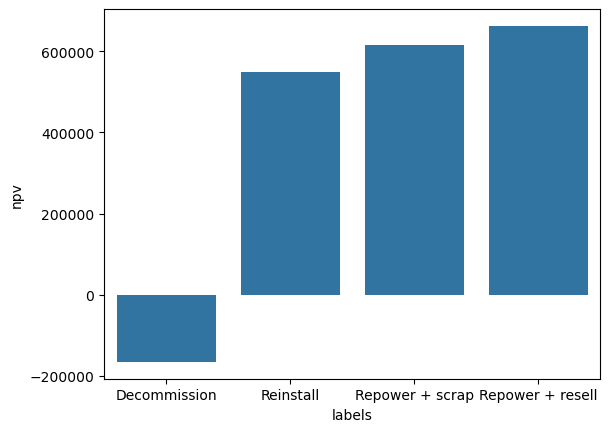

In [28]:
sns.barplot(data, x="labels", y="npv")

<Axes: xlabel='labels', ylabel='payback'>

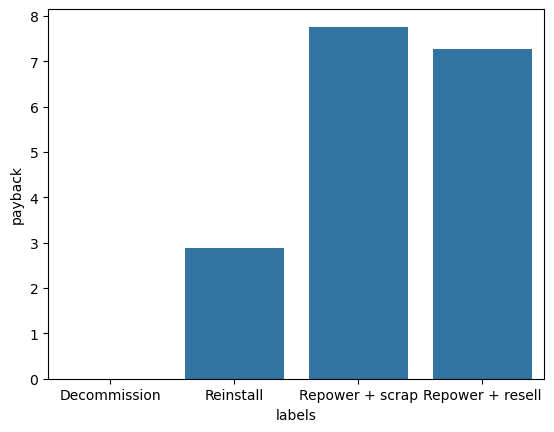

In [29]:
sns.barplot(data, x="labels", y="payback")